In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import warnings
# warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import math

In [2]:
# if torch.cuda.is_available():
#     device=torch.device("cuda")
# else:
#     device=torch.device("cpu")
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
content_path = "dateset_nst/content.jpg"
style_path = "dateset_nst/style.jpg"
# content_path = "dataset_gan/beauty_data/data/16b67.jpg"
# style_path = "dataset_gan/beauty_data/data/22b25.jpg"
# max_size = 400
max_size = 1050
image_mean = (0.485, 0.456, 0.406)
image_std = (0.229, 0.224, 0.225)

In [4]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    """加载图像，并进行Resize、transform操作"""
    image = Image.open(image_path)
    
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform:
        image = transform(image).unsqueeze(0)
    
    return image.to(device)

In [5]:
# 图像处理
# VGGNet在ImageNet数据集上训练的，ImageNet的图像已被归一化为mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
# 这里也进行使用同样的数据进行归一化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)])

In [6]:
# 加载待转换的内容图像content和目标风格图像style
# 两者的大小需要相同
content_image = load_image(content_path, transform, max_size=max_size)
style_image = load_image(style_path, transform, shape=[content_image.size(3), content_image.size(2)])
print(content_image.size())
print(style_image.size())

torch.Size([1, 3, 567, 1050])
torch.Size([1, 3, 567, 1050])


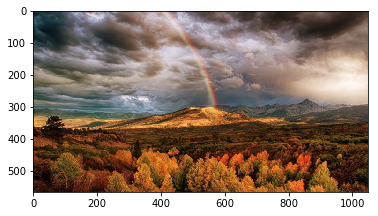

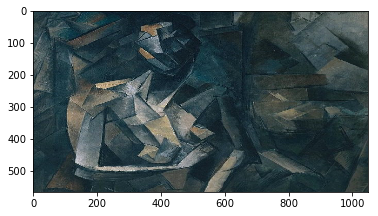

In [8]:
def image_show(image):
    image = image.squeeze(0)
    img = image.numpy().transpose((1,2,0))
    mean = np.array(image_mean)
    std = np.array(image_std)
    img = img*std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

image_show(content_image)
image_show(style_image)

In [49]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        # 选择conv_1到conv_5的激活图
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28'] 
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        # 提取多卷积特征图
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [56]:
def transfer(content, style, total_step=5000, log_step=50, sample_step=500, style_weight=100, lr=0.003):
    #  用content图像初始化一个target图像
    target = content.clone().requires_grad_(True)
    
    optimizer = torch.optim.Adam([target], lr=lr, betas=[0.5, 0.999])
    vgg = VGGNet().to(device).eval() # 切换到eval()模式，省去梯度计算量
    
    for step in range(total_step):
        
        # Extract multiple(5) conv feature vectors
        # 提取多层特征向量
        target_features = vgg(target)
        content_features = vgg(content)
        style_features = vgg(style)

        style_loss = 0
        content_loss = 0
        for f1, f2, f3 in zip(target_features, content_features, style_features):
            # Compute content loss with target and content images
            # 计算content损失：target - content
            content_loss += torch.mean((f1 - f2)**2)

            # Reshape convolutional feature maps
            # Reshape 卷积特征图
            _, c, h, w = f1.size()
            f1 = f1.view(c, h * w)
            f3 = f3.view(c, h * w)

            # Compute gram matrix
            # 计算Gram矩阵（格拉姆矩阵）
            f1 = torch.mm(f1, f1.t())
            f3 = torch.mm(f3, f3.t())

            # Compute style loss with target and style images
            # 计算style损失：tartget - style
            style_loss += torch.mean((f1 - f3)**2) / (c * h * w) 
        
        # Compute total loss, backprop and optimize
        # 计算全部损失，并进行反向传播和优化
        loss = content_loss + style_weight * style_loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step+1) % log_step == 0:
            print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
                   .format(step+1, total_step, content_loss.item(), style_loss.item()))

        if (step+1) % sample_step == 0:
            # Save the generated image
            # 采样保存生成的风格图像
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            img = target.clone().squeeze()
            img = denorm(img).clamp_(0, 1)
            torchvision.utils.save_image(img, 'dateset_nst/output-{}.png'.format(step+1))

In [57]:
total_step = 1
log_step = 50
sample_step = 500
style_weight = 100
lr = 0.003

In [58]:
transfer(content_image, style_image, total_step=total_step, log_step=log_step, sample_step=sample_step, style_weight=style_weight, lr=lr)

torch.Size([1, 64, 216, 400]) torch.Size([1, 64, 216, 400]) torch.Size([1, 64, 216, 400])
torch.Size([64, 86400]) torch.Size([1, 64, 216, 400]) torch.Size([64, 86400])
torch.Size([1, 128, 108, 200]) torch.Size([1, 128, 108, 200]) torch.Size([1, 128, 108, 200])
torch.Size([128, 21600]) torch.Size([1, 128, 108, 200]) torch.Size([128, 21600])
torch.Size([1, 256, 54, 100]) torch.Size([1, 256, 54, 100]) torch.Size([1, 256, 54, 100])
torch.Size([256, 5400]) torch.Size([1, 256, 54, 100]) torch.Size([256, 5400])
torch.Size([1, 512, 27, 50]) torch.Size([1, 512, 27, 50]) torch.Size([1, 512, 27, 50])
torch.Size([512, 1350]) torch.Size([1, 512, 27, 50]) torch.Size([512, 1350])
torch.Size([1, 512, 13, 25]) torch.Size([1, 512, 13, 25]) torch.Size([1, 512, 13, 25])
torch.Size([512, 325]) torch.Size([1, 512, 13, 25]) torch.Size([512, 325])


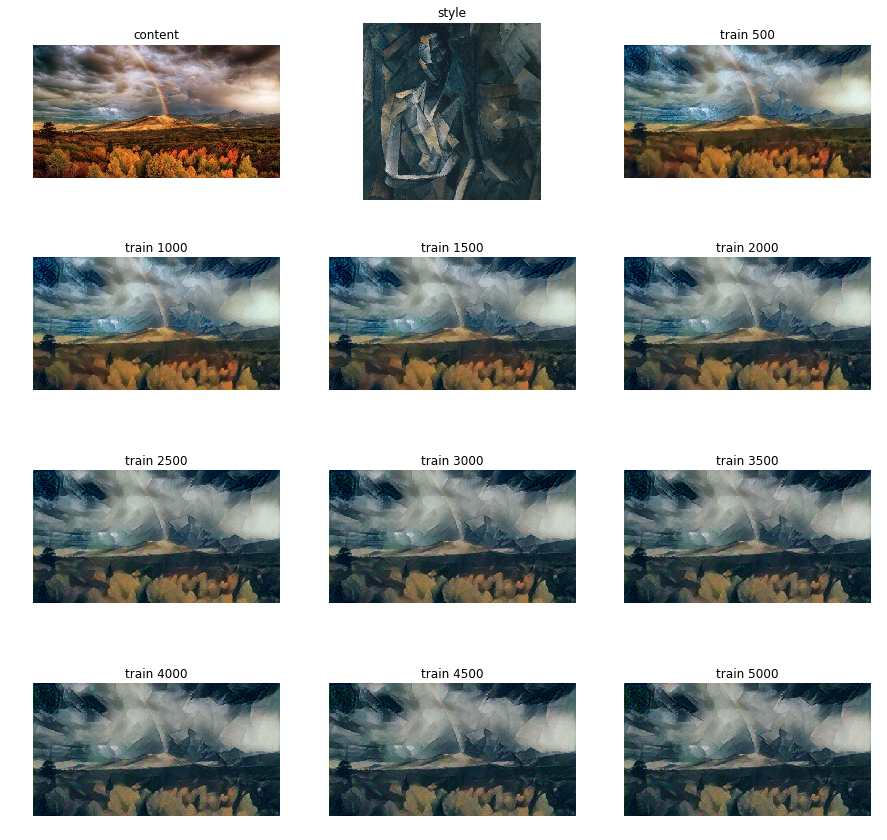

In [32]:
show_index = (500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000)
col = 3
grid_row = math.ceil((len(show_index) + 2) / float(col))
origin = mpimg.imread('dateset_nst/content.jpg')
style = mpimg.imread('dateset_nst/style.jpg')
trans1Img_500 = mpimg.imread('dateset_nst/output-500.png')
trans1Img_2000 = mpimg.imread('dateset_nst/output-2000.png')
trans2Img_3500 = mpimg.imread('dateset_nst/output-3500.png')
trans2Img_5000 = mpimg.imread('dateset_nst/output-5000.png')
plt.figure(figsize=(15,15))

plt.subplot(grid_row,col,1 ) # 显示图片
plt.title("content")
plt.imshow(origin) # 显示图片
plt.axis('off') # 不显示坐标轴

plt.subplot(grid_row,col,2 ) # 显示图片
plt.title("style")
plt.imshow(style) # 显示图片
plt.axis('off') # 不显示坐标轴

for i, index in enumerate(show_index):
    trans_img = mpimg.imread('dateset_nst/output-{}.png'.format(index))
    plt.subplot(grid_row,col,i+3 ) # 显示图片
    plt.title("train {}".format(index))
    plt.imshow(trans_img) 
    plt.axis('off')

# plt.subplot(3,2,3 ) # 显示图片
# plt.title("train 500")
# plt.imshow(trans1Img_500) # 显示图片
# plt.axis('off') # 不显示坐标轴

# plt.subplot(3,2,4 ) # 显示图片
# plt.title("train 2000")
# plt.imshow(trans1Img_2000) # 显示图片
# plt.axis('off') # 不显示坐标轴

# plt.subplot(3,2,5 ) # 显示图片
# plt.title("train 3500")
# plt.imshow(trans2Img_3500) # 显示图片
# plt.axis('off') # 不显示坐标轴

# plt.subplot(3,2,6 ) # 显示图片
# plt.title("train 5000")
# plt.imshow(trans2Img_5000) # 显示图片
# plt.axis('off') # 不显示坐标轴

plt.show()

# =============分割=============